## Requirements

In [ ]:
!pip install nltk
!pip install numpy
!pip install pandas
!pip install textblob
!pip install scikit-learn
!pip install IPython
!pip install matplotlib
!pip install seaborn
!pip install wordninja
!pip install wordcloud

In [58]:
import re
import nltk
import time
import wordninja
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

from datetime import timedelta
from textblob import TextBlob 
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from IPython.display import display, HTML

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/jgonzalez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jgonzalez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jgonzalez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jgonzalez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Data Loading

In [63]:
df = pd.read_csv('data/dataset.csv')
df = df.rename(columns={'Review': 'review', 'Rating': 'rating'})

In [64]:
df.head(5)

,review,rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## Data Pre-processing

### Pre-processing functions and test

In [65]:
hotel_specific_stopwords = [
    # Generic hotel terms (too common to be meaningful)
    'hotel', 'room', 'rooms', 'stay', 'stayed', 'staying',
    'booking', 'booked', 'book',
    'night', 'nights', "resort"
]

preservations = {
            'cannot', 'cant', 'wont', 'dont', 'didnt', 
            'wouldnt', 'couldnt', 'shouldnt', 'hasnt', 
            'havent', 'hadnt', 'isnt', 'arent', 'wasnt', 
            'werent'
        }

def preprocess_text(text):
    processed_words = []
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Basic spell correction using TextBlob
    text = str(TextBlob(text).correct())
    
    # Tokenization
    tokens = word_tokenize(text)

    # Split potentially concatenated words
    for word in tokens:
        if word in preservations:
            processed_words.append(word)
        else:
            split_words = wordninja.split(word)
            processed_words.extend(split_words)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    processed_words = [word for word in processed_words if word not in stop_words and word not in hotel_specific_stopwords]

    # Join tokens back to text
    return ' '.join(processed_words)

def parallel_preprocess(texts, n_cores=6):
    total = len(texts)
    processed_texts = []
    
    print(f"Starting processing of {total} texts...")
    start_time = time.time()
    last_batch_time = start_time
    
    with Pool(n_cores) as pool:
        for i, result in enumerate(pool.imap(preprocess_text, texts)):
            processed_texts.append(result)
            if (i + 1) % 10 == 0:
                current_time = time.time()
                batch_time = current_time - last_batch_time
                total_time = current_time - start_time
                
                print(f"Processed {i + 1}/{total} texts ({((i + 1)/total)*100:.1f}%)")
                print(f"Batch time: {timedelta(seconds=batch_time)} - Total time so far: {timedelta(seconds=total_time)}")                                
                last_batch_time = current_time
    
    total_execution_time = time.time() - start_time
    print(f"Processing completed!")
    print(f"Total execution time: {timedelta(seconds=total_execution_time)}")
    return processed_texts

def show_comparison(original, cleaned, n_samples=5):
    comparison_df = pd.DataFrame({
        'Original Text': original,
        'Cleaned Text': cleaned
    })
    
    # Show random samples
    display(comparison_df.sample(n=n_samples))

def highlight_differences(text1, text2):
    words1 = set(text1.split())
    words2 = set(text2.split())
    
    different_words = words1.symmetric_difference(words2)
    
    html = f"""
    <div style="display: flex; gap: 20px;">
        <div style="flex: 1;">
            <h4>Original:</h4>
            <p>{''.join([f'<span style="background-color: orange">{w}</span> ' if w in different_words else f'{w} ' for w in text1.split()])}</p>
        </div>
        <div style="flex: 1;">
            <h4>Cleaned:</h4>
            <p>{''.join([f'<span style="background-color: orange">{w}</span> ' if w in different_words else f'{w} ' for w in text2.split()])}</p>
        </div>
    </div>
    """
    return HTML(html)

def create_rating_wordcloud(df, rating=None, 
                          title=None,
                          width=800, 
                          height=400,
                          background_color='white',
                          colormap='viridis',
                          max_words=100):
    """
    Create word cloud from reviews with specific rating(s)
    
    Parameters:
    - df: pandas DataFrame with 'rating' and 'cleaned_review' columns
    - rating: int or list of ints (1-5), if None shows all reviews
    - title: custom title, if None auto-generates based on rating
    """
    
    # Filter by rating if specified
    if rating is not None:
        if isinstance(rating, (int, float)):
            df_filtered = df[df['rating'] == rating]
            default_title = f'Word Cloud - Rating {rating}'
        elif isinstance(rating, list):
            df_filtered = df[df['rating'].isin(rating)]
            default_title = f'Word Cloud - Ratings {rating}'
    else:
        df_filtered = df
        default_title = 'Word Cloud - All Ratings'
    
    # Check if we have reviews
    if len(df_filtered) == 0:
        print(f"No reviews found for rating(s): {rating}")
        return None
    
    # Combine all filtered reviews
    text = ' '.join(df_filtered['cleaned_review'].astype(str))
    
    # Create and configure WordCloud
    wordcloud = WordCloud(
        width=width,
        height=height,
        background_color=background_color,
        colormap=colormap,
        max_words=max_words,
        random_state=42
    ).generate(text)
    
    # Plot
    plt.figure(figsize=(width/100, height/100))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title or default_title, fontsize=16, pad=20)
    plt.tight_layout(pad=0)
    plt.show()
    
    # Return word frequencies
    return dict(sorted(wordcloud.words_.items(), 
                      key=lambda x: x[1], 
                      reverse=True))

def plot_rating_distribution(dataset, figsize=(15, 6), palette='viridis'):
    """
    Creates a visualization of rating distribution with bar plot and pie chart.
    
    Parameters:
    -----------
    dataset : pandas DataFrame
        DataFrame containing a 'rating' column
    figsize : tuple, optional
        Figure size for the plots (width, height)
    palette : str, optional
        Color palette to use for the plots
    
    Returns:
    --------
    dict
        Dictionary containing the numerical summaries
    """
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # 1. Bar plot with seaborn
    sns.countplot(data=dataset, x='rating', ax=ax1, palette=palette)
    ax1.set_title('Rating Distribution (Bar Plot)')
    ax1.set_xlabel('Rating')
    ax1.set_ylabel('Count')
    
    # 2. Pie chart with matplotlib
    rating_counts = dataset['rating'].value_counts()
    colors = sns.color_palette(palette, n_colors=len(rating_counts))
    ax2.pie(rating_counts, 
            labels=rating_counts.index, 
            autopct='%1.1f%%', 
            colors=colors)
    ax2.set_title('Rating Distribution (Pie Chart)')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Calculate numerical summaries
    counts = dataset['rating'].value_counts().sort_index()
    percentages = dataset['rating'].value_counts(normalize=True).sort_index().mul(100).round(1)
    
    # Print numerical summary
    print("\nNumerical Summary:")
    print(counts)
    print("\nPercentage Distribution:")
    print(percentages)
    
    # Return the summaries as a dictionary
    return {
        'counts': counts,
        'percentages': percentages
    }

In [66]:
examples = [
    "The room wasnotgood and veryclean",
    "Notbad experience but supercrowded",
    "thebreakfastwasawesome",
    "roomservicewasexcellent",
    "bathroomwasnotclean",
    "wouldntrecommend",
    "can't do that",
    "wouldn't it be nice fatbastard",
    "4* is my goddamn review motherfucker"
]

for sentence in examples:
    print(preprocess_text(sentence))

good clean
noted experience super crowded
breakfast awesome
service excellent
bathroom clean
wouldnt recommend

nice fat bastard
goddamn review motherfucker


### Test pre-processing task with 100 samples

In [67]:
n_samples = 100
df_subset = df.sample(n=n_samples, random_state=42)
df_subset['cleaned_review'] = parallel_preprocess(df_subset['review'], n_cores=10)
df_subset.to_csv('data/cleaned_dataset_100.csv', index=False)
print("Original shape:", df.shape)
print("Subset shape:", df_subset.shape)

Starting processing of 100 texts...
Processed 10/100 texts (10.0%)
Batch time: 0:00:09.983611 - Total time so far: 0:00:09.983611
Processed 20/100 texts (20.0%)
Batch time: 0:00:00.000232 - Total time so far: 0:00:09.983844
Processed 30/100 texts (30.0%)
Batch time: 0:00:02.125854 - Total time so far: 0:00:12.109698
Processed 40/100 texts (40.0%)
Batch time: 0:00:05.669693 - Total time so far: 0:00:17.779390
Processed 50/100 texts (50.0%)
Batch time: 0:00:00.000128 - Total time so far: 0:00:17.779518
Processed 60/100 texts (60.0%)
Batch time: 0:00:03.745183 - Total time so far: 0:00:21.524702
Processed 70/100 texts (70.0%)
Batch time: 0:00:01.088951 - Total time so far: 0:00:22.613653
Processed 80/100 texts (80.0%)
Batch time: 0:00:00.983259 - Total time so far: 0:00:23.596912
Processed 90/100 texts (90.0%)
Batch time: 0:00:04.602475 - Total time so far: 0:00:28.199386
Processed 100/100 texts (100.0%)
Batch time: 0:00:00.000382 - Total time so far: 0:00:28.199769
Processing completed!


In [70]:
df_subset.head()

,review,rating,cleaned_review
10726,not recommend hotel did reviewers actually sta...,1,recommend reviews actually good thing location...
14919,"barcelona rocks, stayed hotel jazz girlfriend ...",4,barcelona rocks jazz girlfriend end augustine ...
19098,ok hotel good location stayed night way beijin...,3,ok good location way raw island service ok loc...
2450,great service nice pool ok beach lovely ground...,4,great service nice pool ok beach lovely ground...
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spent weekend july cartwright...


### Full pre-processing task

Uncomment cell below in order to preprocess the entire dataset and generate a new .csv file (+20k rows so it will take a while)

In [69]:
#df['cleaned_review'] = parallel_preprocess(df['review'], n_cores=10)
#df.to_csv('data/cleaned_dataset_processed.csv', index=False)

## Data Analysis and Exploration

In [71]:
dataset = pd.read_csv('data/cleaned_dataset_100.csv')
dataset.head(5)

,review,rating,cleaned_review
0,not recommend hotel did reviewers actually sta...,1,recommend reviews actually good thing location...
1,"barcelona rocks, stayed hotel jazz girlfriend ...",4,barcelona rocks jazz girlfriend end augustine ...
2,ok hotel good location stayed night way beijin...,3,ok good location way raw island service ok loc...
3,great service nice pool ok beach lovely ground...,4,great service nice pool ok beach lovely ground...
4,surprising treat spent weekend july 15/16 2006...,5,surprising treat spent weekend july cartwright...


In [72]:
sample=6
highlight_differences(dataset['review'][sample], dataset['cleaned_review'][sample])

In [73]:
sample = 45
highlight_differences(dataset['review'][sample], dataset['cleaned_review'][sample])

Word Cloud of rows with rating 1 star

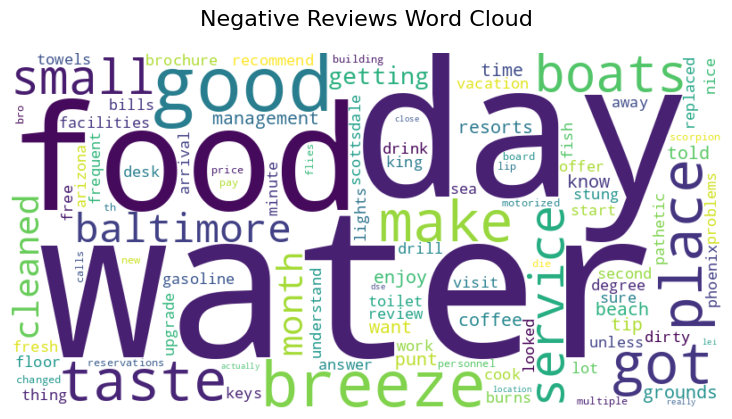

{'water': 1.0,
 'day': 1.0,
 'food': 1.0,
 'good': 0.8571428571428571,
 'breeze': 0.8571428571428571,
 'got': 0.7142857142857143,
 'place': 0.7142857142857143,
 'taste': 0.7142857142857143,
 'make': 0.7142857142857143,
 'boats': 0.5714285714285714,
 'small': 0.5714285714285714,
 'service': 0.5714285714285714,
 'baltimore': 0.5714285714285714,
 'cleaned': 0.42857142857142855,
 'month': 0.42857142857142855,
 'getting': 0.42857142857142855,
 'management': 0.42857142857142855,
 'want': 0.42857142857142855,
 'beach': 0.42857142857142855,
 'know': 0.42857142857142855,
 'enjoy': 0.42857142857142855,
 'time': 0.42857142857142855,
 'resorts': 0.42857142857142855,
 'tip': 0.42857142857142855,
 'grounds': 0.42857142857142855,
 'coffee': 0.42857142857142855,
 'told': 0.42857142857142855,
 'punt': 0.42857142857142855,
 'recommend': 0.2857142857142857,
 'thing': 0.2857142857142857,
 'facilities': 0.2857142857142857,
 'toilet': 0.2857142857142857,
 'floor': 0.2857142857142857,
 'nice': 0.285714285714

In [74]:
create_rating_wordcloud(dataset, 
    rating=1,
    #colormap='Reds',
    title='Negative Reviews Word Cloud')

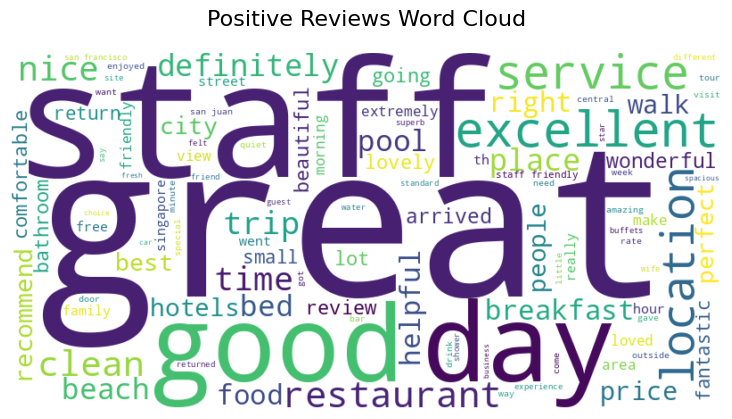

{'great': 1.0,
 'staff': 0.7936507936507936,
 'day': 0.6349206349206349,
 'good': 0.6031746031746031,
 'excellent': 0.5079365079365079,
 'service': 0.4603174603174603,
 'location': 0.4444444444444444,
 'restaurant': 0.4444444444444444,
 'clean': 0.4126984126984127,
 'nice': 0.38095238095238093,
 'time': 0.36507936507936506,
 'trip': 0.3492063492063492,
 'definitely': 0.3333333333333333,
 'place': 0.3333333333333333,
 'bed': 0.31746031746031744,
 'pool': 0.31746031746031744,
 'beach': 0.31746031746031744,
 'breakfast': 0.2857142857142857,
 'helpful': 0.2857142857142857,
 'right': 0.2857142857142857,
 'food': 0.2857142857142857,
 'walk': 0.25396825396825395,
 'price': 0.25396825396825395,
 'recommend': 0.23809523809523808,
 'hotels': 0.23809523809523808,
 'people': 0.23809523809523808,
 'city': 0.2222222222222222,
 'best': 0.2222222222222222,
 'perfect': 0.2222222222222222,
 'wonderful': 0.2222222222222222,
 'arrived': 0.2222222222222222,
 'comfortable': 0.20634920634920634,
 'bathroom':

In [75]:
create_rating_wordcloud(dataset, 
    rating=5,
    #colormap='Reds',
    title='Positive Reviews Word Cloud')

/tmp/ipykernel_32599/90545711.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset, x='rating', ax=ax1, palette=palette)


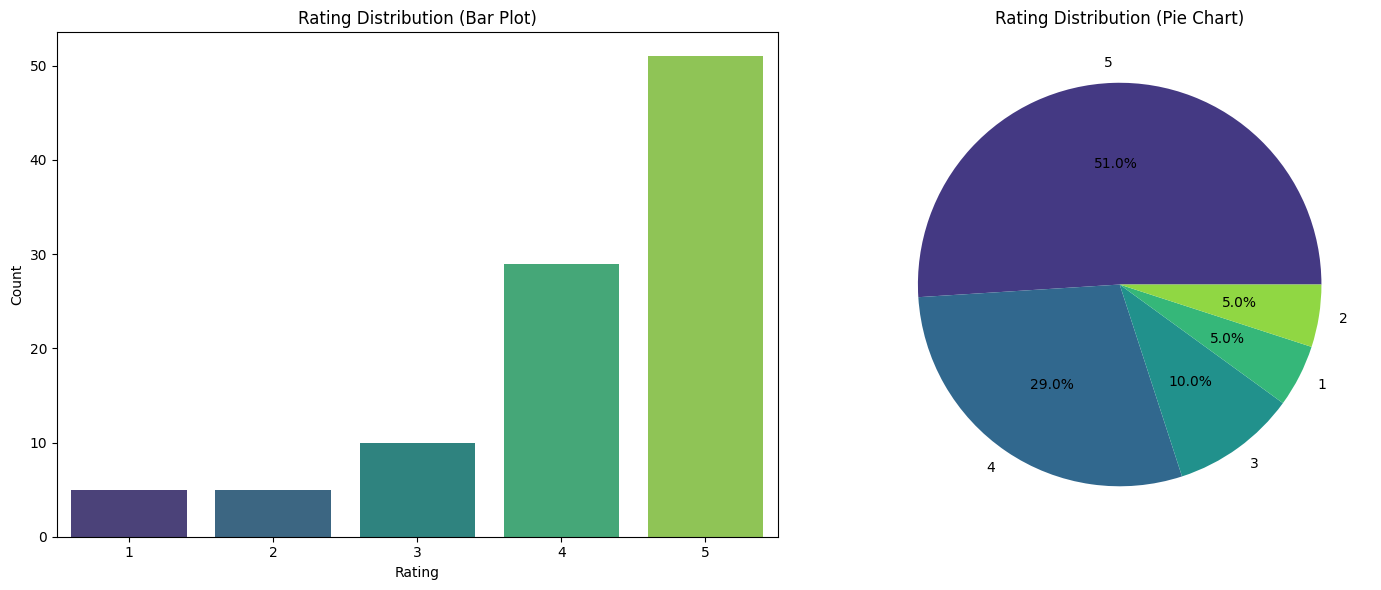


Numerical Summary:
rating
1     5
2     5
3    10
4    29
5    51
Name: count, dtype: int64

Percentage Distribution:
rating
1     5.0
2     5.0
3    10.0
4    29.0
5    51.0
Name: proportion, dtype: float64


In [76]:
summaries = plot_rating_distribution(dataset)